# Завдання 5: Класифікація, Частина 1

В даній практичній роботі будемо досліджувати та створювати класифікатор використовуючи метод k-nearest neighbors.

Необхідно буде створити класифікатор, який визначає, до якого жанру відноситься та чи інша пісня, використовуючи лише кількість слів, які зустрічаються в тексті пісні. В проекті необідно буде:

1. Очистити і впорядкувати набір даних, який використовується для тестування моделі
2. Побудувати класифікатор k-найближчих сусідів
3. Перевірити класифікатор на даних

Для самоконтролю використовуються тести автогрейдера (from gofer.ok import check), як і в поперідній работі. Якщо Ви їх ще не використовували, то для їх викоритання необхідно інсталювати два додаткових модуля (через CMD.exe Prompt в ANACONDA NAVIGATOR) а саме:

- **okgrade** (pip install okgrade) https://okgrade.readthedocs.io/_/downloads/en/latest/pdf/
- **gofer** (pip install git+https://github.com/grading/gradememaybe.git) https://okgrade.readthedocs.io/en/latest/install/

Якщо Ви не бажаєти їх викоритовувати, то закоментуйте відповідний рядок і не використовуйте рядки тесту (наприклад check('tests/q2_1.py'), ...). В такому разі Ви можете переглянути наявні тести у відповідній директорії

In [3]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter('ignore', UserWarning)

# These lines load the tests.
from gofer.ok import check

# 1. Набір даних

Наш набір даних — це таблиця пісень, кожна з яких має назву, виконавця та жанр. Ми спробуємо передбачити жанр кожної пісні.

Єдині атрибути, які ми будемо використовувати для прогнозування жанру пісні, це її слова. Зокрема, у нас є список із трохи менше 5000 слів, які можуть зустрічатися в пісні. Для кожної пісні наш набір даних повідомляє нам про частоту, з якою кожне з цих слів зустрічається в цій пісні. Усі слова перетворено в нижній регістр (на малі літери).

Запустіть комірку нижче, щоб прочитати таблицю `lyrics`. **Завантаження може зайняти до хвилини.**

In [4]:
lyrics = Table.read_table('lyrics.csv')
lyrics.where("Title", "In Your Eyes").select(0, 1, 2, 3, 4, 5, "like", "love")

Title,Artist,Genre,i,the,you,like,love
In Your Eyes,Alison Krauss,Country,0.107143,0,0.0297619,0.0119048,0.0595238


Ця комірка друкує кілька атрибутів (стовпців) об'єкта (рядка) для кантрі-пісні ["In Your Eyes" Alison Krauss](http://www.azlyrics.com/lyrics/alisonkrauss/inyoureyes.html). Пісня містить 168 слів. Слово "like" з’являється двічі: $\frac{2}{168} \approx 0.0119$ з усіх слів у пісні (отже оперуємо ймовірністю). Слово "love" з’являється 10 разів: $\frac{10}{168} \approx 0.0595$ з усіх слів. Слово "the" не з'являється взагалі.

Набір даних містить не всю інформацію про пісню. Наприклад, він не описує порядок слів у пісні, не кажучи вже про мелодію, інструменти чи ритм. Тим не менш, Ви можете відмітити для себе, що для побудови точного класифікатора жанрів достатньо лише частоти з якою зустрічаються слова.

All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [5]:
title_index = lyrics.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    lyrics.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

Наприклад, найшвидший спосіб дізнатися частоту з якою зустрічається слово "love" у пісні *In Your Eyes* — отримати доступ до елемента (item - пам'ятайте про модуль datascience) `'love'` з його рядка.

In [6]:
row_for_title('In Your Eyes').item('love')

0.059523810000000003

** <b>Завдання 1.1</b> ** <br/>

Встановіть для `expected_row_sum` числове значання, яке Ви очікуєте отримати в результаті підсумовування всіх частот по словах (а по-суті ймовірностей) у кожному рядку, за винятком перших трьох стовпців (`Title`, `Artist`, `Genre`).

In [34]:
# Встановіть для expected_row_sum число, яке є (приблизною) сумою пропорцій зістрічі слів для кожного рядка. 
# Згадайте про ймовірності.
expected_row_sum = 1

In [35]:
check("tests/q1_1.py")

Запустіть комірку нижче, щоб створити гістограму фактичних сум по рядах. Це має підтвердити Вашу відповідь надану вище, можливо, з невеликою кількістю похибок (внаслідок округлень).

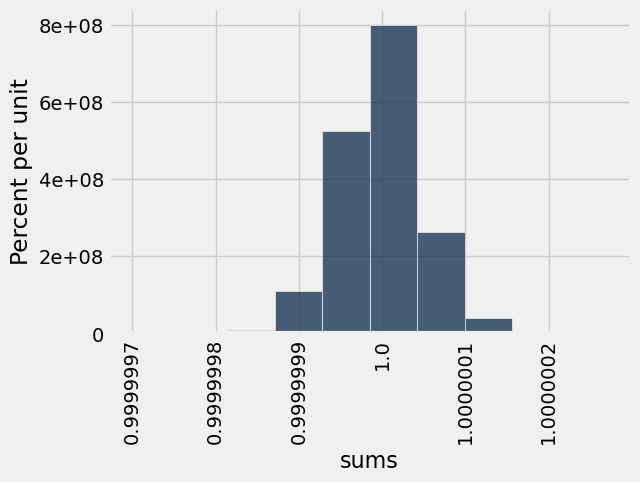

In [15]:
# Run this cell to display a histogram of the sums of proportions in each row.
# This computation might take up to a minute; you can skip it if it's too slow.
Table().with_column('sums', lyrics.drop([0, 1, 2]).apply(sum)).hist(0)

Цей набір даних було взято з [Computational and Inferential Thinking](https://inferentialthinking.com/chapters/intro.html),  [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/). Також, додатково використовується набори даних з [musiXmatch](http://labrosa.ee.columbia.edu/millionsong/musixmatch) і [Last.fm](http://labrosa.ee.columbia.edu/millionsong/lastfm).

Кількість загальних слів у текстах усіх цих пісень задається набором даних musiXmatch (так званий формат bag-of-words). Попередньо всі слова переведено у нижній регістр, видалено некоректні слова і символи та проведено підрахунок ймовірності з якою слова зустрічаються у піснях.

Набір даних Last.fm містить кілька тегів для кожної пісні в наборі Million Song Dataset. Деякі теги пов’язані з жанрами, як-то "pop", "rock", "classic" тощо. Щоб створити стовпець `Genre`, було спочатку відібрано пісні з тегами Last.fm, які містили слова "country", або "hip" і "hop". Потім ці пісні були співвіднесені з набором даних musiXmatch, і лише пісні з текстами musixMatch були вибрані у наш набір даних.

In [16]:
print('Words with frequencies:', lyrics.drop('Title', 'Artist', 'Genre').num_columns)
print('Songs with genres:', lyrics.num_rows)

Words with frequencies: 4817
Songs with genres: 1721


## 1.1. Словозміна

Стовпці, окрім `Title`, `Artist`, `Genre`, у таблиці `lyrics` — це всі слова, які з’являються в деяких піснях у нашому наборі даних. Деякі з цих слів були *обрізані* або скорочі евристичними методами, щоб спробувати перетворити різні [словозмінні](https://en.wikipedia.org/wiki/Inflection) форми одного основного слова до одного рядка. Наприклад, колонка "manag" — це сума пропорцій слів "manage", "manager", "managed" і "managerial" (і, можливо, інших) у кожній пісні.

*Однокорінні* (stemmed) слова трохи ускладнюють пошук слів, які ви хочете використати, тому також використаємо іншу таблицю, яка дозволить побачити приклади *однокорінних*  слів співведнесених з основним словом. Запустіть наведений нижче код, щоб завантажити таблицю.

In [17]:
# Just run this cell.
vocab_mapping = Table.read_table('mxm_reverse_mapping_safe.csv')
stemmed = np.take(lyrics.labels, np.arange(3, len(lyrics.labels)))
vocab_table = Table().with_column('Stem', stemmed).join('Stem', vocab_mapping)
vocab_table.take(np.arange(1100, 1106))

Stem,Word
devant,devant
devast,devastation
devil,devil
devot,devotion
devour,devour
dew,dew


** <b>Завдання 1.1.1</b> ** <br/>

Визначте значення змінної `percent_unchanged` як **відсоток** слів у `vocab_table`, які збігаються з їх основною формою (наприклад, "devour" у колонці `Stem` та `Word` у прикладі вище).

*Підказка:* Спробуйте використати `where` (з модуля datascience (http://www.data8.org/datascience/_autosummary/datascience.tables.Table.where.html)) знайти кількість рядків у таблиці з незмінними формами у обох колонках (*are.equal_to* - для вибірки, та *num_rows* - для кількості), а потім знайти співвідношення до загальної кількісті рядків (*num_rows*) у `vocab_table`. Перевести у відсоткі. Наприклад: `marbles.where("Price", are.equal_to, "Amount").num_rows`

In [18]:
num_unchanged = vocab_table.where('Stem', are.equal_to, vocab_table.column('Word')).num_rows
num_total = vocab_table.num_rows
percent_unchanged = num_unchanged / num_total * 100
print(round(percent_unchanged, 2), 'percent are unchanged')

71.77 percent are unchanged


In [19]:
check("tests/q1_1_1.py")

** <b>Завдання 1.1.2</b> ** <br/>

Визначте значення змінної `stemmed_message` для основної форми слова "message" (з колонки `Word`). Спробуйте використати `where`

In [20]:
# Set stemmed_message to the stemmed version of "message" (which
# should be a string).  Use vocab_table.
stemmed_message = vocab_table.where('Word', are.equal_to('message')).column('Stem').item(0)
stemmed_message

'messag'

In [21]:
check("tests/q1_1_2.py")

** <b>Завдання 1.1.3</b> ** <br/>

Визначте значення змінної `unstemmed_singl` для однокорінної (*stemmed*) форми слова "singl" з таблиці `vocab_table` (з колонки `Stem`). (*Зауважте, що кілька англійських слів можуть мати початок "singl", але лише один віріант відображається в таблиці `vocab_table`.*)

In [22]:
# Set unstemmed_singl to the unstemmed version of "singl" (which
# should be a string).
unstemmed_singl = vocab_table.where('Stem', 'singl').column('Word').item(0)
unstemmed_singl

'single'

In [23]:
check("tests/q1_1_3.py")

## 1.2. Розбиття набору даних

Ми будемо використовувати наш набір даних `lirics` для двох цілей.

1. По-перше, ми хочемо *навчити* класифікатор жанрів пісень.
2. По-друге, ми хочемо *перевірити* продуктивність нашого класифікатора.

Отже, нам потрібні два різні набори даних: *training* (*навчальна вибірка*) та *test* (*тестова вибірка*).

Метою класифікатора є класифікація невидимих даних, подібних до навчальної вибірки. Тому ми повинні переконатися, що в обох наборах немає однакових пісень. Ми робимо це шляхом випадкового розділення набору даних. Набір даних уже переставлено випадковим чином, тому його легко розділити. Ми просто беремо верхню частину таблиці для навчання, а решту для тесту.

Але Ви можете використати і метод `sample` а потім `take` (як в лекції).

Поки ж, запустіть наведений нижче код (не змінюючи його), щоб розділити набори даних на дві таблиці.

In [24]:
# Here we have defined the proportion of our data
# that we want to designate for training as 11/16ths
# of our total dataset.  5/16ths of the data is
# reserved for testing.

training_proportion = 11/16

num_songs = lyrics.num_rows
num_train = int(num_songs * training_proportion)
num_valid = num_songs - num_train

train_lyrics = lyrics.take(np.arange(num_train))
test_lyrics = lyrics.take(np.arange(num_train, num_songs))

print("Training: ",   train_lyrics.num_rows, ";",
      "Test: ",       test_lyrics.num_rows)

Training:  1183 ; Test:  538


Запустіть наведений нижче код, щоб відобразити горизонтальну гістограму з двома стовпчиками, які показують частку кантрі-пісень у кожному наборі даних. Ми використовуємо функцію `country_proportion`, щоб допомогти створити гістограму.

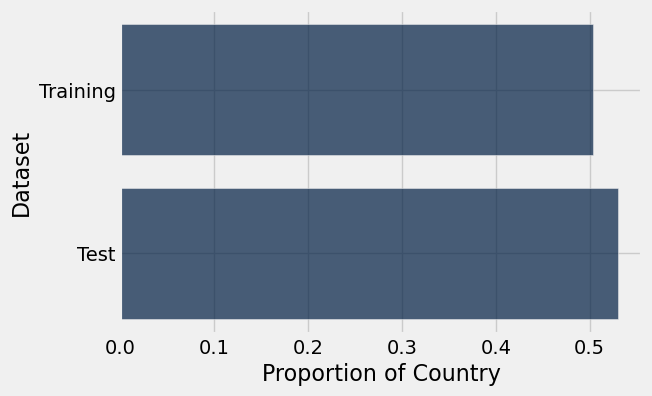

In [25]:
def country_proportion(table):
    """Return the proportion of songs in a table that have the Country genre."""
    return table.where('Genre', are.equal_to('Country')).num_rows / table.num_rows

Table().with_columns(
        'Dataset', make_array('Training', 'Test'),
        'Proportion of Country', make_array(country_proportion(train_lyrics), country_proportion(test_lyrics)))\
       .barh('Dataset')

# 2. K-Nearest Neighbors - навчання з вчителем

K-Nearest Neighbors (k-NN) — це алгоритм класифікації. Враховуючи деякі *атрибути* (також звані *ознаками*) нового об'єкту, він вирішує, чи належить цей об'єкт до одного чи іншого класу на основі його схожості з раніше проаналізованими об'єктами. Прогнозування категорії об'єкту називається *класифікацією*, а передбачена категорія також називається *класом*.

Атрибут (особливість), який ми маємо для кожної пісні, — це *частка випадків, коли певне слово з’являється в тексті*, а класи — це два музичні жанри: hip-hop і country. Алгоритм потребує багатьох досліджених об'єктів, для яких відомі як атрибути, так і класи: це таблиця `train_lyrics`.

Щоб краще зрозуміти, ми збираємося візуалізувати алгоритм, а не просто описувати його.

## 2.1. Класифікація пісні

У k-NN ми класифікуємо пісню, знаходячи `k` пісень в *навчальній вибірці*, які 
схожі за обраними нами ознаками. Пісні зі схожими характеристиками ми називаємо *найближчими сусідами*. Алгоритм k-NN відносить пісню до найпоширенішої категорії серед її найближчих `k` сусідів.

Наразі обмежимося лише двома атрибутами, щоб ми могли побудувати діаграму для кожної пісні. Атрибути, які ми будемо використовувати, це пропорції слів "like" і "love" в тексті. Якщо взяти пісню "In Your Eyes" (у тестовому наборі), то 0.0119 її слів є «like», а 0.0595 — «love». Ця пісня є в тестовому наборі, тож уявімо, що ми ще не знаємо її жанру.

По-перше, нам потрібно уточнити наше поняття подібності. Ми скажемо, що *відстань* між двома піснями є лінійною відстанню між ними, коли ми наносимо їхні характеристики на точкову діаграму. Ця відстань називається евклідовою, формула якої: $\sqrt{(x_1 - x_2)^2 - (y_1 - y_2)^2}$.

Наприклад, у пісні *Insane in the Brain* (у навчальному наборі) 0.0203 усіх слів у пісні є «like», а 0 — «love». Її відстань від *In Your Eyes* у цьому наборі ознак із двох слів становить $\sqrt{(0.0119 - 0.0203)^2 + (0.0595 - 0)^2} \approx 0.06$. (Якби ми включили більше ознак або інші ознаки, відстань могла б бути іншою.)

Третя пісня, *Sangria Wine* (у навчальному наборі), має 0.0044 "love" і 0.0925 "love".

Наведена нижче функція створює діаграму для відображення ознак "love" та "love" тестової пісні та деяких навчальних пісень. Як ви бачите в результаті, *In Your Eyes* більше схожий на *Sangria Wine*, ніж на *Insane in the Brain*.

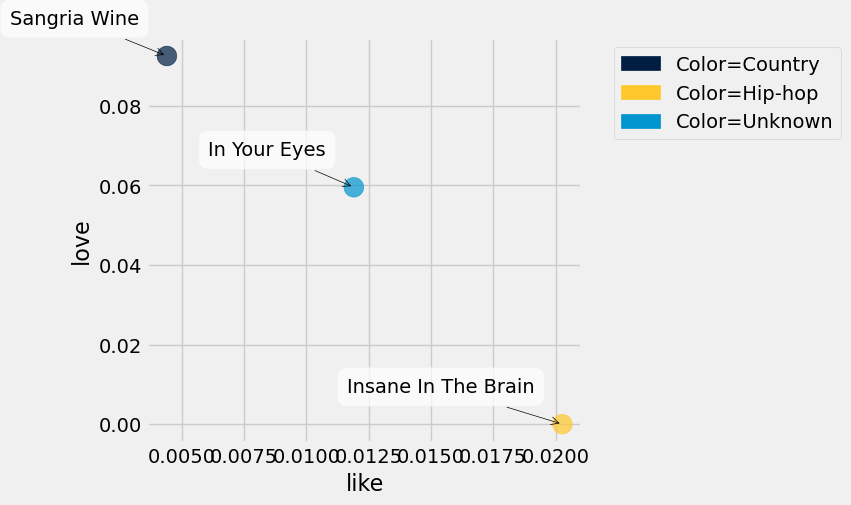

In [26]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['Unknown'],
            'Title',   [test_song]
        )
    for song in training_songs:
        row = row_for_title(song)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), song])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=200)
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

** <b>Завдання 2.1.1</b> ** <br/>

Обчисліть відстань між двома кантрі-піснями, *In Your Eyes* і *Sangria Wine*, використовуючи лише обзнаки `like` та `love`. Збережіть результат у змінну `country_distance`.

**Примітка 1:** Якщо у вас є об’єкт рядка, ви можете використовувати `item`, щоб отримати значення зі стовпця за його назвою. Наприклад, якщо `r` – це рядок, то `r.item("Genre")` є значенням у стовпці `"Genre"` у рядку `r`.

**Примітка 2:** Ви можете швидко отримати рядок із таблиці `lirics` через `row_for_title`. Наприклад, якщо «Insane In The Brain» є назвою пісні, то `row_for_title(«Insane In The Brain»)` є об’єктом рядка для цієї пісні.

**Примітка 3:** Ви можете визначити додаткові функції для цієї задачі (хоча це і необов'язково зараз). Наприклад як ми це робили у лекції 8 (файл lec9.ipynb), коли визначали функції `distance` та `distance_from_rows`.

In [27]:
in_your_eyes = row_for_title("In Your Eyes")
sangria_wine = row_for_title("Sangria Wine")

def distance_from_rows(row1, row2):
    features = ["like", "love"]
    dist = 0
    for feature in features:
        dist += (row1.item(feature) - row2.item(feature)) ** 2
    return dist ** 0.5

country_distance = distance_from_rows(in_your_eyes, sangria_wine)
country_distance

0.033828944324596891

In [28]:
check("tests/q2_1_1.py")

Функція `plot_with_two_features` може показувати позиції кількох навчальних пісень. Нижче ми додали одну, яка ще ближче до *In Your Eyes*.

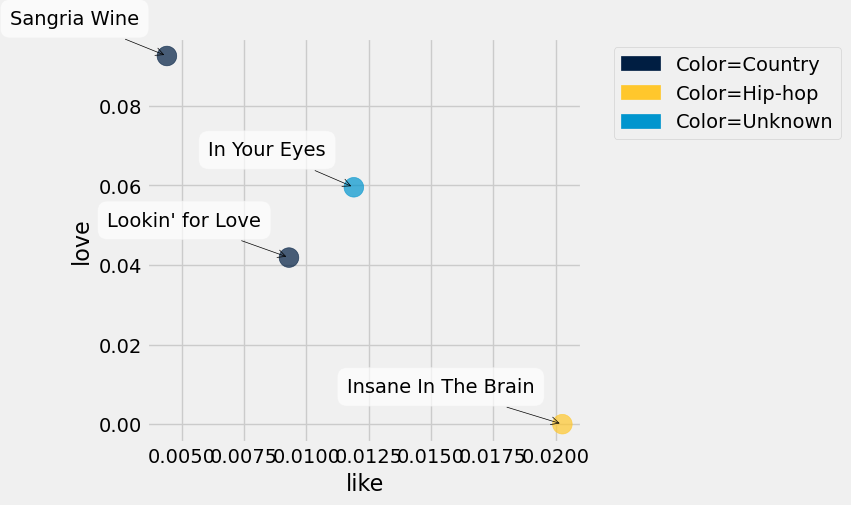

In [29]:
training = ["Sangria Wine", "Lookin' for Love", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

** <b>Завдання 2.1.2</b> ** <br/>

Завершіть написання функції `distance_two_features`, яка обчислює евклідову відстань між будь-якими двома піснями, використовуючи дві ознаки. Останні два рядки викликають вашу функцію, щоб показати, що *Lookin' for Love* ближче до *In Your Eyes*, ніж до *Insane In The Brain*.

In [32]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two songs with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    x0, y0 = row0.item(x_feature), row0.item(y_feature)
    x1, y1 = row1.item(x_feature), row1.item(y_feature)
    return ((x0 - x1) ** 2 + (y0 - y1) ** 2) ** 0.5

for song in make_array("Lookin' for Love", "Insane In The Brain"):
    song_distance = distance_two_features(song, "In Your Eyes", "like", "love")
    print(song, 'distance:\t', song_distance)


Lookin' for Love distance:	 0.0178540259516
Insane In The Brain distance:	 0.0601087823407


False

In [33]:
check("tests/q2_1_2.py")

** <b>Завдання 2.1.3</b> ** <br/>

Завершіть написання функції `distance_from_in_your_eyes`, щоб вона знаходила відстань між даною піснею та "In Your Eyes", використовуючи ознаки "like" та "love"

In [36]:
def distance_from_in_your_eyes(title):
    """The distance between the given song and "In Your Eyes", based on the features "like" and "love".
    
    This function takes a single argument:
      title: A string, the name of a song.
    """
    return distance_two_features(title, "In Your Eyes", "like", "love")

In [37]:
check("tests/q2_1_3.py")

** <b>Завдання 2.1.4</b> ** <br/>

Використовуючи ознаки `"like" і "love"`, які знайдіть назви та жанри 7 пісень у **навчальній вібірці**, які найближчі до "In Your Eyes"? Щоб відповісти на це запитання, створіть таблицю під назвою `close_songs`, що містить ці 7 пісень зі стовпцями `"Title"`, `"Artist"`, `"Genre"`, `"like"` та `"love"`, а також стовпець під назвою `"distance"`, який містить відстань від "In Your Eyes" до цих пісень. Таблиця має бути **відсортована в порядку зростання за `distance`**.

**Примітка:** Згадайте як ми це робили у лекції 8 (файл lec9.ipynb). Або зверніться до підручника - https://inferentialthinking.com/chapters/17/3/Rows_of_Tables.html

In [47]:
close_songs = lyrics.select("Title", "Artist", "Genre", "like", "love").with_column("distance", lyrics.apply(distance_from_in_your_eyes, "Title"))
close_songs.sort("distance").show(7)


Title,Artist,Genre,like,love,distance
In Your Eyes,Alison Krauss,Country,0.0119048,0.0595238,0
Dear Life,Anthony Hamilton,Hip-hop,0.00913242,0.0547945,0.00548198
If This Isn't Love,Jennifer Hudson,Hip-hop,0.00886918,0.0532151,0.00700106
Southern Loving,Jim Ed Brown & The Browns,Country,0.00423729,0.0635593,0.00866461
My Maria,B.W. Stevenson,Country,0.00591716,0.0532544,0.00866928
Love Come Down,"Evelyn Champagne"" King""",Hip-hop,0,0.0594714,0.0119049
Big Red Rocket Of Love,Reverend Horton Heat,Hip-hop,0,0.0576923,0.0120448


In [48]:
check("tests/q2_1_4.py")

** <b>Завдання 2.1.5</b> ** <br/>

Завершіть написання функції `most_common`, щоб вона повертала найпоширеніший клас у стовпці таблиці. (Нагадаємо, що це колонка `"Genre"` )

In [50]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    counts_table = table.group(label)
    sorted_counts = counts_table.sort("count", descending=True)
    most_common_values = sorted_counts.column(label).item(0)
    return most_common_values

# Calling most_common on your table of 7 nearest neighbors classifies
# "In Your Eyes" as a country song, 4 votes to 3.
most_common('Genre', close_songs)

'Country'

In [51]:
check("tests/q2_1_5.py")

Вітаємо – ви класифікували свою першу пісню!

## Контроль

Ви закінчили з даною частиною практичної роботи! Аби перевірити, що всі завдання виконані вірно, виконайте наступні дії...
- **ВАЖЛИВО** Перш ніж щось робити, виберіть, **Save and Checkpoint** з меню `File`. Будь ласка, зробіть це спочатку, перш ніж запускати клітинку нижче,
- **запустіть усі тести та перевірте, чи всі вони пройшли успішно** (у наступній клітинці є перевірка для цього), 
- **Перегляньте notebook востаннє, перевірятися буде остаточний стан вашого notebook. Якщо ви вносили будь-які зміни, збережіть і запустіть всі рядки ще раз** Якщо ви вносили будь-які зміни, запустіть поллідовно всі рядки ще раз і збережіть **Save and Checkpoint** повторно.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from gofer.ok import grade_notebook
if not globals().get('__GOFER_GRADER__', False):
    display(grade_notebook('pr5_5.ipynb', sorted(glob.glob('tests/q*.py'))))